# Generating the Mercator grid for 1/4 degree ocean

In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

# Mercator projection


For a given $(longitude,latitude) = (\lambda, \phi)$ the isotropic Mercator projection can be written as:  
$$\begin{equation}
y = M(\phi) = R \ln \left[ 1+\sin\phi \over \cos\phi \right].  
\end{equation}$$
The corresponding inverse function can be written as:
$$\begin{equation}
\phi = M^{-1}(y) = \tan^{-1}\left(\sinh(y/R)\right).
\end{equation}$$

Here $R$ is called the representative fraction (RF) or the principal scale of the projection (in units of the radius of the (isotropic) Earth $a_E$). E.g., to project the earth surface to a rectangular map of width $L$ one can use a principal scale of $L/(2\pi a_{E})$ (which corresponds to a "globe" of radius $L/2\pi$.)

These are one of a few equivalent analytic forms of the projection function. For an overview and more information refer to [https://en.wikipedia.org/wiki/Mercator_projection](the wikipedia).


# Defining a Mercator grid


We want to generate an isotropic Mercator grid corresponding to a 1/4 degree resolution at the equator. Here are the defining parameters of our super-grid:

 
1. The grid cell resolution in longitude direction $\Delta \lambda = {1/8}^\circ $.  
2. The grid cell resolution in latitude  direction shall be the same as in longitude direction at the equator $\Delta \phi(\phi=0) = \Delta \lambda$. 

So:
  
1. To achieve 1. above we partition the equator to $N_x$ intervals. The condition 1. above fixes $N_x=2880$ , since  $\Delta \lambda = (1/8)(\pi/180) = {2\pi\over N_x}$.
2. To achieve 2. above we need to calculate $\Delta y$ given $\Delta \phi$:
$$\begin{equation*}
\Delta \phi = \Delta y \left. ({d\phi \over dy}) \right|_{y=0} = \Delta y {1\over R} {\cosh(y/R) \over 1+\sinh^2(y/R)} |_{y=0} = {\Delta y \over R}
\end{equation*}$$

Now 1. and 2. fix the value of the projection scale $R$ as follows:
$$\begin{equation}
R = {\Delta y \over \Delta \phi}|_{y=0} = {\Delta y \over \Delta \lambda}|_{y=0} = {1 \over (\delta \lambda /N_x)} = {N_x \over 2\pi}
\end{equation}$$


Note that we treat $y$ as an index in the latitude direction $\Delta y = \Delta j =1 $!


## Specification via approximate latitude bounds

If we are given $Nx$, $\tilde{\Phi}_s$, $\tilde{\Phi}_n$ then:
\begin{align}
R &= \frac{Nx}{2\pi} \\
y_s &= {int} (\tilde{\Phi}_s) \\
y_n &= {int} (\tilde{\Phi}_n)
\end{align}
and
\begin{align}
\Phi_s &= \Phi(y_s) \\
\Phi_n &= \Phi(y_n)
\end{align}
where $\Phi_s \neq \tilde{\Phi}_s$ and $\Phi_n \neq \tilde{\Phi}_n$

In [2]:
import numpy as np
def y_mercator(Ni, phi):
    R = Ni / (2 * np.pi)
    return R * ( np.log( (1.0 + np.sin(phi) ) / np.cos(phi)) )
def phi_mercator(Ni, y):
    R = Ni / (2 * np.pi)
    return np.arctan( np.sinh(y/R) ) * (180/np.pi) # Converted to degrees
def y_mercator_rounded(Ni, phi):
    y_float = y_mercator(Ni, phi)
    return ( np.sign(y_float) * np.ceil( np.abs(y_float) ) ).astype(int)
# Specify approximate latitude range
#phi_s, phi_n = -64.00422531295267, 61.247692871618455
phi_s, phi_n = -64, 61.24
# Diagnose nearest integer y(phi range)
y_star = y_mercator_rounded(2880, np.array([phi_s*np.pi/180,phi_n*np.pi/180]))
print( 'y*=',y_star, 'nj=', y_star[1]-y_star[0] )
print( 'Actual phi range: phi_s,phi_n=', phi_mercator(2880, y_star) )
print( 'Grid =', phi_mercator(2880, np.arange(y_star[0],y_star[1]+1)) )

y*= [-672  624] nj= 1296
Actual phi range: phi_s,phi_n= [-64.00422531  61.24769287]
Grid = [-64.00422531 -63.94938346 -63.89443401 ...  61.12720664  61.18750733
  61.24769287]


In [3]:
phi_mercator(2880, np.arange(-672,624+1))

array([-64.00422531, -63.94938346, -63.89443401, ...,  61.12720664,
        61.18750733,  61.24769287])

# Generating a Mercator grid via package MIDAS

The code snippet below uses the MIDAS package to generate the Mercator grid. We first want to study the calls in this package to find out how MIDAS has been generating the grids. Note that this "import"s a class that was isolated from original MIDAS, hence we call it "pymidas" to distinguish it from the whole package. This is a small fraction of MIDAS and is pure Python.

Note: I am generating this notebook with anaconda Python 3 on my workstation. 

First let's take a look at the grid generated straight from pymidas for a given longitude (since the grid is homogeneous in x direction).

In [4]:
from pymidas.rectgrid_gen import supergrid
import numpy as np

refine=2  # Set to 2 for GIS_025 grid and 4 for GIS_0125
lat0=-65.0 # This is a nominal starting latitude for Mercator grid
lon0=-300. # Starting longitude
lenlat=125. # nominal latitude range of Mercator grid
lenlon=360. 
nx=1440*refine
ny=1296 #700*refine

#### Begin Mercator Grid

print ('constructing a mercator supergrid with (ny,nx) = ',ny,nx)
print ('nominal starting lat and starting longitude =',lat0, lon0)
print ('and nominal width in latitude = ',lenlat)

mercator=supergrid(nxtot=nx,xstart=lon0,lenx=lenlon,
                   nytot=ny,ystart=lat0,leny=lenlat,
                   config='mercator',axis_units='degrees',cyclic_x=True)

mercator.grid_metrics()
mercator.write_nc('mercator_supergrid.nc')

print ("mercator max/min latitude=", mercator.y.max(),mercator.y.min())
print ("mercator nj,ni=", mercator.y.shape[0]-1,mercator.y.shape[1]-1)
print ("mercator starting longitude=",mercator.x[0,0])
print ("mercator ending longitude=",mercator.x[0,-1])

print("mercator start/end longitudes=",mercator.y[0,0],mercator.y[-1,0])

constructing a mercator supergrid with (ny,nx) =  1296 2880
nominal starting lat and starting longitude = -65.0 -300.0
and nominal width in latitude =  125.0
mercator max/min latitude= 61.247692871618455 -64.00422531295267
mercator nj,ni= 1296 2880
mercator starting longitude= -300.0
mercator ending longitude= 60.0
mercator start/end longitudes= -64.00422531295267 61.247692871618455


In [5]:
import matplotlib.pyplot as plt

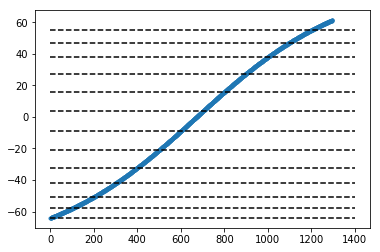

In [6]:
plt.plot( mercator.y[:,0], '.');
for j in np.arange(0,ny+1,100):
    plt.plot([0,1400],[mercator.y[j,0],mercator.y[j,0]],linestyle='dashed',color='black')

Or in terms of latitude degrees rather than the y-index.

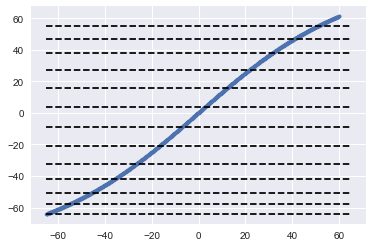

In [7]:
import seaborn as sns; sns.set()
PI_180 = np.pi/180.
y0=lat0
geo_lat=np.zeros(ny+1)
for j in np.arange(ny+1):
    geo_lat[j] = y0 + j * lenlat/ny
plt.plot(geo_lat, mercator.y[:,0], '.');

for j in np.arange(0,ny+1,100):
    plt.plot([-65,65],[mercator.y[j,0],mercator.y[j,0]],linestyle='dashed',color='black')

Notice that at first glance this y-grid is unlike what one expects from a "Mercator projection". A Mercator projection (equation 1) is supposed to get stretched (and diverge) as we move towards the poles giving rise to the famous illusion of the Greenland and Antarctica being bigger than Africa (which in fact they are only a fraction of). This is not the fault of the software, we are looking at the wrong mapping! A Mercator map is not the same as a Mercator grid, in fact they have an inverse map relation. The above figure is a representation of equation 2. 

# Southern Ocean spherical grid

## MIDAS

In [8]:
from pymidas.rectgrid_gen import supergrid
import numpy as np
refine=2  # Set to 2 for GIS_025 grid and 4 for GIS_0125
lat0=-65.0 # This is a nominal starting latitude for Mercator grid
lon0=-300. # Starting longitude
lenlat=125. # nominal latitude range of Mercator grid
lenlon=360. 
nx=1440*refine
ny=700*refine
ny2=110*refine
lat0_sp=-78.0

#### Begin Spherical Grid for Southern Ocean
print ('constructing a spherical supergrid with (ny,nx) = ',ny,nx)
print ('nominal starting lat and starting longitude =',lat0, lon0)
print ('and nominal width in latitude = ',lenlat)
spherical=supergrid(nx,ny2,'spherical','degrees',lat0_sp,mercator.y.min()-lat0_sp,lon0,lenlon,cyclic_x=True)
spherical.grid_metrics()
spherical.write_nc('antarctic_spherical_supergrid.nc')
print ("antarctic spherical max/min latitude=", spherical.y.max(),spherical.y.min())
print ("spherical nj,ni=", spherical.y.shape[0]-1,spherical.y.shape[1]-1)
print ("spherical starting longitude=",spherical.x[0,0])
print ("spherical ending longitude=",spherical.x[0,-1])


constructing a spherical supergrid with (ny,nx) =  1400 2880
nominal starting lat and starting longitude = -65.0 -300.0
and nominal width in latitude =  125.0
antarctic spherical max/min latitude= -64.00422531295267 -78.0
spherical nj,ni= 220 2880
spherical starting longitude= -300.0
spherical ending longitude= 60.0


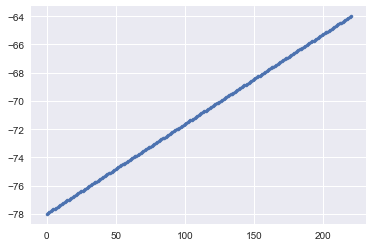

In [9]:
plt.plot( spherical.y[:,0], '.');

## Simple line

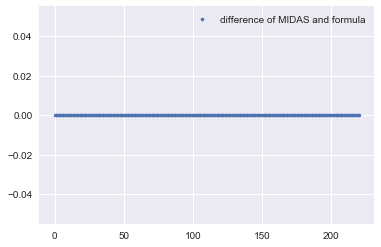

In [10]:
#for j in np.arange(ny+1):
#    y = y0 + j* PI_180 * lenlat/ny
#    grid_y_mercator[j] = np.arctan(np.sinh(y/R)) / PI_180

lenlat_sp = mercator.y.min()-lat0_sp #Should replace mercator.y.min with the formula
grid_y_sp = np.zeros(ny2+1)
jindp_sp  = np.arange(ny2+1)
grid_y_sp = lat0_sp+jindp_sp*lenlat_sp/ny2
plt.plot( spherical.y[:,0] - grid_y_sp[:], '.',label="difference of MIDAS and formula") ;
plt.legend(loc=0);

Note the difference is due to the difference between our formula generated starting latitude of Mercator grid grid_y_mercator[0] and MIDAS generated quantity mercator.y[0,0]

Put together with the our Mercator it looks like this.

Note: The arrays overlap at the joint!

end lattude of SouthernSP -64.00422531295267
start lattude of Mercator -64.00422531295267


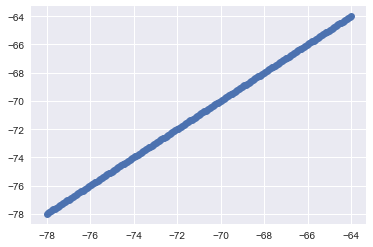

In [11]:
lenlat_sp = mercator.y.min()-lat0_sp #Should replace mercator.y.min with the formula
geo_lat=np.zeros(ny2+ny+3)

for j in np.arange(ny2+1):
    geo_lat[j] = lat0_sp + j * lenlat_sp/ny2

for j in np.arange(1,ny+3):
    geo_lat[ny2+j] = geo_lat[ny2] + j * lenlat/ny

print("end lattude of SouthernSP", grid_y_sp[-1])    
print("start lattude of Mercator", mercator.y[0,0])    

plt.plot(geo_lat[:ny2+1], grid_y_sp[:], 'o');
#plt.plot(geo_lat[ny2+2:], mercator.y[:,0], '.');



#plt.plot(geo_lat, mercator.y[:,0], '.');
#plt.plot(geo_lat[:ny2+1], spherical.y[:,0], '.');
#plt.plot(geo_lat[ny2+2:], mercator.y[:,0], '.');

# Tripolar grid

## MIDAS

In [103]:
refine=2  # Set to 2 for GIS_025 grid and 4 for GIS_0125
lat0=-65.0 # This is a nominal starting latitude for Mercator grid
lon0=-300. # Starting longitude
lenlat=125. # nominal latitude range of Mercator grid
lenlon=360. 
nx=1440*refine
ny=700*refine

ny_ncap=119*refine
lat0_tp=mercator.y.max()
dlat=90.0-lat0_tp
tripolar_n=supergrid(nx,ny_ncap,'spherical','degrees',lat0_tp,dlat,lon0,360.,tripolar_n=True)
tripolar_n.grid_metrics()
tripolar_n.write_nc('ncap_supergrid.nc')
print ("generated a tripolar supergrid of size (ny,nx)= ",tripolar_n.y.shape[0]-1,tripolar_n.y.shape[1]-1)
print ("tripolar grid starting longitude = ",tripolar_n.x[0,0])
print ("tripolar grid starting latitude = ",tripolar_n.y[0,0])
print (np.shape(tripolar_n.x) , np.shape(tripolar_n.y))

generated a tripolar supergrid of size (ny,nx)=  238 2880
tripolar grid starting longitude =  -300.0
tripolar grid starting latitude =  61.24769287161847
(239, 2881) (239, 2881)


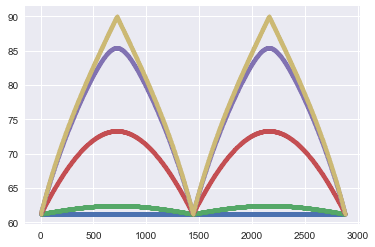

In [104]:
plt.plot( tripolar_n.y[0,:], '.');
plt.plot( tripolar_n.y[10,:], '.');
plt.plot( tripolar_n.y[100,:], '.');
plt.plot( tripolar_n.y[200,:], '.');
plt.plot( tripolar_n.y[238,:], '.');

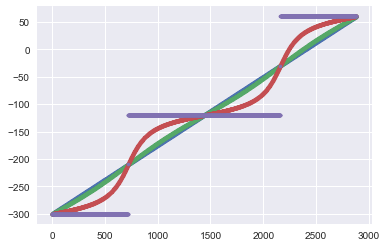

In [105]:
plt.plot( tripolar_n.x[1,:], '.');
plt.plot( tripolar_n.x[100,:], '.');
plt.plot( tripolar_n.x[200,:], '.');
plt.plot( tripolar_n.x[238,:], '.');


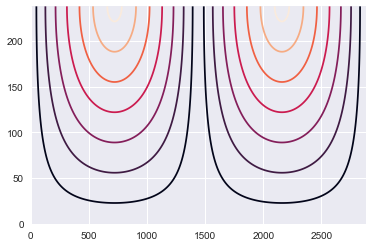

In [106]:
plt.contour(tripolar_n.y)

In [16]:
def plot_grid0(sp_grid_x,sp_grid_y,lon0=0):

    from mpl_toolkits.basemap import Basemap
    import matplotlib
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(10,7))
    # You can set negative contours to be solid instead of dashed:
    matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

    # setup north polar stereographic basemap.
    # The longitude lon_0 is at 6-o'clock, and the
    # latitude circle boundinglat is tangent to the edge
    # of the map at lon_0. Default value of lat_ts
    # (latitude of true scale) is pole.
    map = Basemap(projection='stere',lon_0=lon0,lat_0=0,resolution='l')

    x,y = map(sp_grid_x,sp_grid_y)

    #print(np.shape(x), np.shape(y)) #(239, 2881) (239, 2881)

    cs_x = map.contour(x,y,sp_grid_y,colors='k',linewidths=1.0)
    cs_y = map.contour(x,y,sp_grid_x,colors='k',linewidths=1.0)

    #map.drawcoastlines()   




In [24]:
def plot_grid_stere(lon_grid,lat_grid, grid_x,grid_y,lon0=0,coastline=False):

    from mpl_toolkits.basemap import Basemap
    import matplotlib
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(10,7))
    # You can set negative contours to be solid instead of dashed:
    matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

    # setup north polar stereographic basemap.
    # The longitude lon_0 is at 6-o'clock, and the
    # latitude circle boundinglat is tangent to the edge
    # of the map at lon_0. Default value of lat_ts
    # (latitude of true scale) is pole.
    map = Basemap(projection='stere',lat_0=0,lon_0=lon0,resolution='l',
                  llcrnrlon=lon0-20, llcrnrlat=-50, urcrnrlon=lon0+20, urcrnrlat=50)

    mx,my = map(lon_grid,lat_grid)

    #print(np.shape(x), np.shape(y)) #(239, 2881) (239, 2881)

    cs_x = map.contour(mx,my, grid_y,colors='k',linewidths=1.0)
    cs_y = map.contour(mx,my, grid_x,colors='r',linewidths=1.0, levels=np.linspace(lon0, lon0+360, 20))
    plt.clabel(cs_y, inline=1, fontsize=10)
    if(coastline) :
        map.drawcoastlines()   




In [35]:
def plot_grid(lon_grid,lat_grid, grid_x,grid_y,lon0=0,coastline=False):

    from mpl_toolkits.basemap import Basemap
    import matplotlib
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(10,7))
    # You can set negative contours to be solid instead of dashed:
    matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

    # setup north polar stereographic basemap.
    # The longitude lon_0 is at 6-o'clock, and the
    # latitude circle boundinglat is tangent to the edge
    # of the map at lon_0. Default value of lat_ts
    # (latitude of true scale) is pole.
    map = Basemap(projection='npstere',boundinglat=60,lon_0=lon0,resolution='l')

    mx,my = map(lon_grid,lat_grid)

    #print(np.shape(x), np.shape(y)) #(239, 2881) (239, 2881)

    cs_x = map.contour(mx,my, grid_y,colors='k',linewidths=1.0)
#    cs_y = map.contour(mx,my, grid_x,colors='r',linewidths=1.0, levels=np.linspace(lon0, lon0+360, 20))
    cs_y = map.contour(mx,my, grid_x,colors='r',linewidths=1.0, levels=np.arange(lon0, lon0+360, 10))
    plt.clabel(cs_y, inline=1, fontsize=10)
    if(coastline) :
        map.drawcoastlines()   




\lambda_c and \phi_c are longitude and latitude of the point X on the spherical grid.
\lambda_s and \phi_s are longitude and latitude of the point X on the projected-re-projected dipolar grid.
\Phi_P the latitude of the bounding parallel of tripolar cap.
\lambda_0 is the longitude of the rotated (bipolar) equator (longitude of the displaced pole).

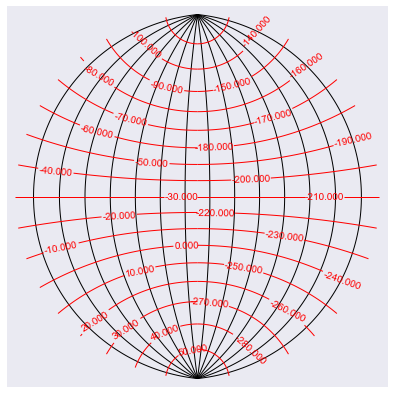

In [108]:
refine=2  # Set to 2 for GIS_025 grid and 4 for GIS_0125
nxtot=1440*refine
nytot=119*refine
lon0=-300.   # Starting longitude, this will be the longitude of the  bi-pole(s)
lenx=360. 
lat0=mercator.y.max()
leny=90.0-lat0
#Spherical grid 
jindp=np.arange(nytot+1);iindp=np.arange(nxtot+1)        
sp_y=lat0+jindp*leny/nytot  #array([61.24769287, 61.36850088, ..., 89.87919199, 90.  ])
sp_x=lon0+iindp*lenx/nxtot 
sp_grid_x = np.tile(sp_x,(nytot+1,1)) #(239, 2881)
sp_grid_y = np.tile(sp_y.reshape((nytot+1,1)),(1,nxtot+1)) #(239, 2881)

def mdist(x1,x2):
  """Returns positive distance modulo 360."""
  a=np.mod(x1-x2+720.,360.)
  b=np.mod(x2-x1+720.,360.)
  d=np.minimum(a,b)
  return d

rp=np.tan(0.5*(0.5*np.pi - (sp_grid_y[0])*PI_180)) #Murray section 2.2 before Eq(6) r_p=tan(\phi_P\prime /2) 
                                                   #where \phi_P is the latitude of the bounding parrallel lat0
##MIDAS lon,lat=self.tp_trans():
##MIDAS lamc=self.bp_lon() #Why is this lon?
chi=2.0*np.arctan(np.tan(0.5*(0.5*np.pi-sp_grid_y*PI_180))/rp) #Murray Inverse of Eq(5b) 
#lamc = 0.5*np.pi - chi  #Why??????????
#lamc[:,:(nxtot//2)] = lamc[:,:(nxtot//2)] - np.pi/2
#lamc[:,(nxtot//2):] =-lamc[:,(nxtot//2):] + np.pi/2
#OR equivalently
lamc = - chi  #Why??????????
lamc[:,:(nxtot//2)] =  lamc[:,:(nxtot//2)] 
lamc[:,(nxtot//2):] =- lamc[:,(nxtot//2):] 
##phic=self.bp_colat() #Why is this co-lat in  MIDAS?
phic=mdist(sp_grid_x,lon0) *PI_180
##phic=(sp_grid_x-lon0) *PI_180 
chic =np.arccos(np.sin(phic)*np.cos(lamc))    #Murray Eq(6) assuming phic is 90-phic !! ***********??
#chic =np.arccos(np.cos(phic)*np.cos(lamc))    #Murray Eq(6) the grid does not make sense !!
tp_grid_y = 90 - np.arctan(rp*np.tan(chic/2.0)) * 2/PI_180 #Murray Eq(5b) for \phi_s
tp_grid_x = np.arctan(np.tan(phic)*np.sin(lamc)) /PI_180   #Murray part of Eq(5a)  assuming phic is 90-phic !!
#The following gymnastics in Midas is missing from Murray paper. 
#Does this accomplish 90-atan(sin(\lambda_c)tan(\phi_c))?
tp_grid_x[:,:nxtot//4]=-tp_grid_x[:,:nxtot//4]
tp_grid_x[:,nxtot//4]=90.0
tp_grid_x[:,nxtot//4+1:nxtot//2]=180.0-tp_grid_x[:,nxtot//4+1:nxtot//2]
tp_grid_x[:,nxtot//2]=180.
tp_grid_x[:,nxtot//2+1:3*nxtot//4]=180.0-tp_grid_x[:,nxtot//2+1:3*nxtot//4]
tp_grid_x[:,3*nxtot//4]=270.
tp_grid_x[:,3*nxtot//4+1:]=360.-tp_grid_x[:,3*nxtot//4+1:]
tp_grid_x = tp_grid_x + lon0 #Murray part of Eq(5a)  

plot_grid( tp_grid_x,tp_grid_y, sp_grid_x,sp_grid_y,lon0)

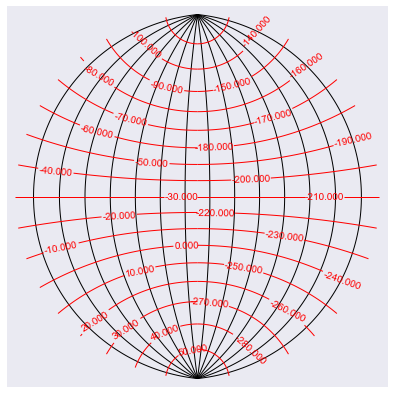

In [111]:
plot_grid(tripolar_n.x, tripolar_n.y, sp_grid_x,sp_grid_y,lon0)

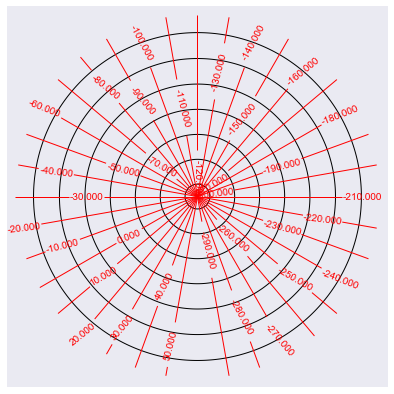

In [37]:
plot_grid(sp_grid_x,sp_grid_y, sp_grid_x,sp_grid_y,lon0)

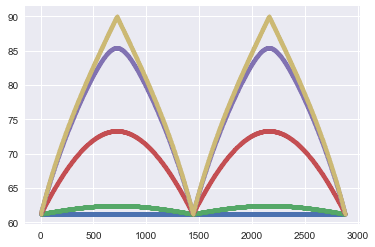

In [109]:
plt.plot( tp_grid_y[0,:], '.');
plt.plot( tp_grid_y[10,:], '.');
plt.plot( tp_grid_y[100,:], '.');
plt.plot( tp_grid_y[200,:], '.');
plt.plot( tp_grid_y[238,:], '.');

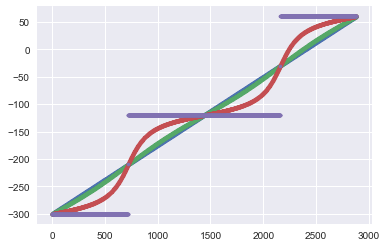

In [110]:
plt.plot( tp_grid_x[1,:], '.');
plt.plot( tp_grid_x[100,:], '.');
plt.plot( tp_grid_x[200,:], '.');
plt.plot( tp_grid_x[238,:], '.');
